# Word2Vec

In [97]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [148]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
import spacy
import en_core_web_lg

import dlnlputils
from dlnlputils.data import (
    tokenize_text_simple_regex,
    tokenize_corpus,
    build_vocabulary,
    texts_to_token_ids,
    PaddedSequenceDataset,
    Embeddings,
)
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Загрузка данных и подготовка корпуса

In [149]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [150]:
# # токенизируем
# train_tokenized = tokenize_corpus(
#     train_source,
#     tokenizer=tokenize_text_simple_regex,
#     min_token_size=0,
# )
# test_tokenized = tokenize_corpus(
#     test_source,
#     tokenizer=tokenize_text_simple_regex,
#     min_token_size=0,
# )

In [151]:
# !python3 -m spacy download en_core_web_lg

In [152]:
spacy_nlp = en_core_web_lg.load(disable=['parser', 'ner'])

In [153]:
def tokenize_corpus_with_spacy(
    texts, spacy_nlp, lemmatize=False, with_pos=False, delim="_"
):
    tokenized_corpus = list(spacy_nlp.pipe(texts))
    result = []

    for doc in tokenized_corpus:
        tokenized_text = []

        for token in doc:
            token_cont = token.text if not lemmatize else token.lemma_

            if with_pos:
                token_cont += delim + token.pos_

            tokenized_text.append(token_cont)

        result.append(tokenized_text)

    return result


LEMMATIZE_MODE_SPACY_TOKENIZER = True
POS_ADD_MODE_SPACY_TOKENIZER = True
DELIM = "_"

In [154]:
# токенизируем с SpaCy
train_tokenized = tokenize_corpus_with_spacy(
    train_source,
    spacy_nlp,
    lemmatize=LEMMATIZE_MODE_SPACY_TOKENIZER,
    with_pos=POS_ADD_MODE_SPACY_TOKENIZER,
    delim=DELIM,
)
test_tokenized = tokenize_corpus_with_spacy(
    test_source,
    spacy_nlp,
    lemmatize=LEMMATIZE_MODE_SPACY_TOKENIZER,
    with_pos=POS_ADD_MODE_SPACY_TOKENIZER,
    delim=DELIM,
)

In [155]:
print("\n".join(" ".join(sent) for sent in train_tokenized[:10]))

1/4_NUM cup_NOUN sour_ADJ cream_NOUN
10_NUM ounce_NOUN swordfish_NOUN ,_PUNCT red_ADJ snapper_NOUN or_CCONJ other_ADJ firm_NOUN -_PUNCT flesh_VERB fish_NOUN
1_NUM tablespoon_NOUN mince_VERB basil_NOUN leave_VERB
handful_ADJ fresh_ADJ parsley_NOUN ,_PUNCT finely_ADV mince_VERB
4_NUM ounce_NOUN lard_NOUN or_CCONJ butter_NOUN ,_PUNCT plus_CCONJ more_ADJ for_ADP brush_VERB top_NOUN
4_NUM to_PART 5_NUM green_ADJ cardamom_NOUN pod_NOUN
1_NUM stick_NOUN (_PUNCT 1/4_NUM pound_NOUN )_PUNCT unsalted_ADJ butter_NOUN ,_PUNCT soften_VERB
1/4_NUM teaspoon_NOUN red_ADJ pepper_NOUN flake_NOUN ,_PUNCT preferably_ADV turkish_ADJ or_CCONJ Aleppo_PROPN (_PUNCT see_VERB note_NOUN )_PUNCT ,_PUNCT more_ADJ to_PART taste_VERB
1_NUM tablespoon_NOUN fresh_ADJ lemon_NOUN juice_NOUN
1/4_NUM cup_NOUN scallion_NOUN ,_PUNCT thinly_ADV slice_VERB


In [156]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2774
[('<PAD>', 0), ('1_NUM', 1), (',_PUNCT', 2), ('cup_NOUN', 3), ('2_NUM', 4), ('tablespoon_NOUN', 5), ('1/2_NUM', 6), ('teaspoon_NOUN', 7), ('and_CCONJ', 8), ('or_CCONJ', 9)]


In [157]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

16 3 277 72
117 26 1008 2 46 655 9 156 750 11 815 235
1 5 32 123 71
1446 22 62 2 28 32
21 26 674 9 34 2 64 84 39 699 666
21 15 73 82 399 494
1 211 12 16 18 14 70 34 2 319
16 7 46 17 175 2 104 1407 9 856 12 131 177 14 2 84 15 23
1 5 22 48 44
16 3 113 2 88 50


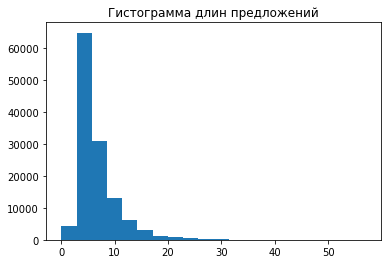

In [158]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [159]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([ 16,   3, 277,  72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [160]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [161]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [162]:
# VOCAB_SIZE = len(vocabulary)

# NEGATIVE_SAMPLES_N = 25
# BATCH_SIZE = 8
# LEARNING_RATE = 1e-2
# RADIUS = 5

# EMBEDDING_SIZE = 100
# EPOCH_N = 2

VOCAB_SIZE = len(vocabulary)

NEGATIVE_SAMPLES_N = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
RADIUS = 3

EMBEDDING_SIZE = 100
EPOCH_N = 10

In [163]:
print(f"Настройки: VOCAB_SIZE = {VOCAB_SIZE}, NEGATIVE_SAMPLES_N = {NEGATIVE_SAMPLES_N}, BATCH_SIZE = {BATCH_SIZE}, LEARNING_RATE = {LEARNING_RATE}, RADIUS = {RADIUS}, EMBEDDING_SIZE = {EMBEDDING_SIZE}, EPOCH_N = {EPOCH_N}")

Настройки: VOCAB_SIZE = 2774, NEGATIVE_SAMPLES_N = 25, BATCH_SIZE = 32, LEARNING_RATE = 0.01, RADIUS = 3, EMBEDDING_SIZE = 100, EPOCH_N = 10


In [164]:
trainer = SkipGramNegativeSamplingTrainer(VOCAB_SIZE, EMBEDDING_SIZE, MAX_SENTENCE_LEN,
                                          radius=RADIUS, negative_samples_n=NEGATIVE_SAMPLES_N)

In [165]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=LEARNING_RATE,
                                            epoch_n=EPOCH_N,
                                            batch_size=BATCH_SIZE,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 5.12 сек
Среднее значение функции потерь на обучении 0.6837635520158679
Среднее значение функции потерь на валидации 0.6747461413612956
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 5.62 сек
Среднее значение функции потерь на обучении 0.6734967747668753
Среднее значение функции потерь на валидации 0.6726144930661754
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 6.85 сек
Среднее значение функции потерь на обучении 0.6721450676922796
Среднее значение функции потерь на валидации 0.6720971529720936
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 5.52 сек
Среднее значение функции потерь на обучении 0.6712723651091973
Среднее значение функции потерь на валидации 0.6723189664568625

Эпоха 4
Эпоха: 2001 итераций, 5.21 сек
Среднее значение функции потерь на обучении 0.6706537901312634
Среднее значение функции потерь на валидации 0.6723375288839494
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 5
Эпоха: 2001 итераций, 6.16 сек
С

In [166]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), 'models/sgns.pth')

In [167]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [168]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [169]:
# print("embeddings.most_similar('chicken')")
# # print("Out:")
# embeddings.most_similar('chicken')

In [170]:
# print("embeddings.analogy('cake', 'cacao', 'cheese')")
# # print("Out:")
# embeddings.analogy('cake', 'cacao', 'cheese')

In [171]:
# # test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
# test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
# test_vectors = embeddings.get_vectors(*test_words)
# print(test_vectors.shape)

In [172]:
# fig, ax = plt.subplots()
# fig.set_size_inches((10, 10))
# plot_vectors(test_vectors, test_words, how='svd', ax=ax)

In [173]:
print("embeddings.most_similar('chicken_NOUN')")
# print("Out:")
embeddings.most_similar('chicken_NOUN')

embeddings.most_similar('chicken_NOUN')


[('chicken_NOUN', 0.9999471),
 ('stock_NOUN', 0.5937826),
 ('turkey_NOUN', 0.56244886),
 ('duck_NOUN', 0.5497401),
 ('broth_NOUN', 0.53921604),
 ('pheasant_NOUN', 0.5330454),
 ('veal_NOUN', 0.5325875),
 ('beef_NOUN', 0.50705683),
 ('skate_NOUN', 0.5021599),
 ('breast_NOUN', 0.5007763)]

In [174]:
print("embeddings.analogy('cake_NOUN', 'cacao_NOUN', 'cheese_NOUN')")
# print("Out:")
embeddings.analogy('cake_NOUN', 'cacao_NOUN', 'cheese_NOUN')

embeddings.analogy('cake_NOUN', 'cacao_NOUN', 'cheese_NOUN')


[('cacao_NOUN', 1.0826366),
 ('cheese_NOUN', 0.96782404),
 ('70_NUM', 0.73867005),
 ('queso_NOUN', 0.71897376),
 ('percent_NOUN', 0.70799565),
 ('solid_NOUN', 0.6984317),
 ('blanco_NOUN', 0.67209536),
 ('Muenster_PROPN', 0.67171854),
 ('Gruyère_PROPN', 0.6555697),
 ('chocolate_NOUN', 0.6345702)]

In [175]:
# embeddings.most_similar('chicken')

In [176]:
# embeddings.analogy('cake', 'cacao', 'cheese')

In [178]:
# # test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
# test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
# test_vectors = embeddings.get_vectors(*test_words)
# print(test_vectors.shape)

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches((10, 10))
# plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [20]:
import gensim

In [21]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [ ]:
word2vec.wv.most_similar('chicken')

In [ ]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [ ]:
import gensim.downloader as api

In [ ]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

In [ ]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

In [ ]:
pretrained.most_similar('cheese')

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [ ]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают